# 프로젝트: Vocabulary Size를 변경해서 시도해보기

목표
- 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출
- Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석
- 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석

## ML 파이프라인 설계

조건이 어지간히 까다롭다.
셀단위로 나누는 것은 매우 비효율 적임으로 고도의 추상화를 기획하자

![](https://github.com/crlotwhite-mirror/AiffelOnline4/blob/main/Going_Deeper_NLP/GD_NLP_2/diagram1.png?raw=true)

1. 전처리 파이프라인을 생성하는 함수를 설계 하되, 인자로 단어 갯수 받도록 설계
2. 공통데이터를 각 모델에 순차적으로 적용하여, 학습을 마친다.
3. 각 모델을 마침과 동시에 평가를 진행하고 기록한다.
4. 이를 시각화 한다.
5. 분석한다.

In [3]:
# GPU 사용 여부 확인
import tensorflow as tf

# GPU 장치 리스트
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# 사용 가능한 GPU 장치 확인
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Num GPUs Available:  1
Default GPU Device: /device:GPU:0


## 라이브러리 임포트

In [4]:
import tensorflow
import matplotlib
import seaborn as sns
import numpy 
import pandas as pd
import sklearn

print(tensorflow.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(numpy.__version__)
print(pd.__version__)
print(sklearn.__version__)

2.10.1
3.7.1
0.12.2
1.25.0
2.0.2
1.2.2


# 분류기 호출

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt

## 데이터 살펴보기

In [6]:
# 임시로 생성
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

In [7]:
# 전체 데이터 수 파악
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [8]:
# 샘플 출력
print(x_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [9]:
# 레이블 수 파악
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


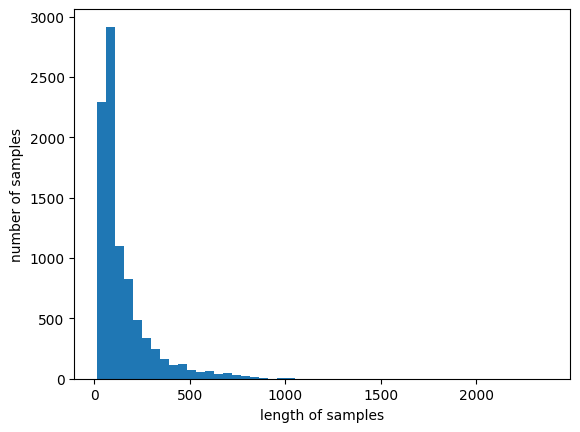

In [10]:
# 데이터 분포 분석
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

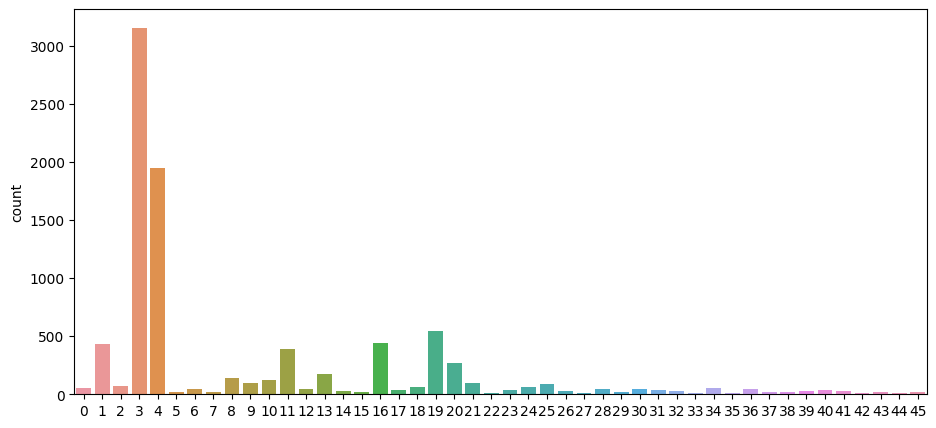

In [11]:
# 클래스 분포 파악
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

## 전처리

1. 데이터 불러오기
2. 단어 사전 생성
3. 원시 데이터로 디코딩
4. DTM 생성 및 훈련
5. TFIDF 생성 및 훈련
6. 테스트 데이터 처리

In [12]:
def get_reuters_datasets(num_words=10000, test_split=0.2):
    def decode(data, i2w):
        return [' '.join([i2w[i] for i in review]) for review in data]

    # 데이터 로딩
    (X_train, y_train), (X_test, y_test) =\
          reuters.load_data(num_words=num_words, test_split=test_split)

    # 데이터셋에서 사용된 단어의 인덱스를 가져옵니다.
    word_index = reuters.get_word_index()

    # 인덱스를 단어로 매핑하는 딕셔너리를 만듭니다.
    index_to_word = {index+3: word for word, index in word_index.items()}
    index_to_word[0] = "<PAD>"
    index_to_word[1] = "<START>"
    index_to_word[2] = "<UNKNOWN>"  # unknown
    index_to_word[3] = "<UNUSED>"

    # 훈련 데이터를 텍스트로 변환합니다.
    X_train_text = decode(X_train, index_to_word)
    X_test_text = decode(X_test, index_to_word)

    # CountVectorizer를 사용하여 DTM을 생성합니다.
    vectorizer = CountVectorizer()
    X_train_dtm = vectorizer.fit_transform(X_train_text)

    # TfidfTransformer를 사용하여 TF-IDF를 생성합니다.
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_dtm)

    # Test 데이터 처리
    X_test_dtm = vectorizer.transform(X_test_text)
    X_test_tfidf = tfidf_transformer.transform(X_test_dtm)
    
    return {
        'num_words': num_words,
        'train': {
            'x': X_train_tfidf,
            'y': y_train
        },
        'test': {
            'x': X_test_tfidf,
            'y': y_test 
        },

    }


실험 환경에서 사용할 첫번째 변수인 단어수는 5천, 10천, 15천개이다.  
이는 단순히 노드에서 언급한 10천 개라는 수치에 5천을 더하거나 뺸 값이다.

In [13]:
# 데이터셋을 담은 리스트 생성
datasets = [ get_reuters_datasets(num_words=x) for x in [5000, 10000, 15000] ] # 단어수 별로 데이터셋 생성

## 학습 준비

다음으로 필요한 준비는 학습 모델이다.  

이번 과제의 중요성은 첫번째 변수에 의해 다르게 생성된 데이터에 대해서 많은 모델에 실험해보는 것이다.

나는 이를 위해 일괄적으로 테스트할 수 있는 루틴을 구현하려고 한다.

~~다만, 안정성을 위해 멀티프로세싱을 일단 배제하고 설계했다.~~

설계하는 과정에서 약간 변경되었다. 

과하게 속도가 느려서 멀티 프로세싱을 도입했다.


In [14]:
# 모델 리스트 생성

models = [
    (MultinomialNB, {}), # 나이브 베이즈 분류기
    (ComplementNB, {}), # 컴플리먼트 나이브 베이즈
    (LogisticRegression, {'C':10000, 'penalty': 'l2', 'max_iter': 3000}), # 로지스틱 회귀
    (LinearSVC, {'C':1000, 'penalty': 'l1', 'max_iter': 3000, 'dual': False}), # 서포트 벡터 머신
    (DecisionTreeClassifier, {'max_depth': 10, 'random_state': 0}), # 결정 트리
    (RandomForestClassifier, {'n_estimators': 5, 'random_state': 0}), # 랜덤 포레스트
    (GradientBoostingClassifier, {'random_state': 0}), # 그래디언트 부스팅
]

# 이미 있는 조건을 이용해서 voting 앙상블 구성
models.append(
    (VotingClassifier, 
        {
            'voting': 'soft', 
            'estimators': [(models[x][0].__name__, models[x][0](**models[x][1])) for x in [2, 1, 6]]
        }
    )
)

## 학습 루틴과 평가 루틴 시작

1. 모델 클래스 가져옴
2. 모델 생성
3. 모델 학습
4. 평가 지표 출력
5. 공통 사전 (dict)에 저장

너무 느려서 멀티프로세싱을 도입함.

아래의 코드는 그 이전의 코드이다.

```python
common_dict = {}

for model, kwargs in models:
    common_dict[model.__name__] = {'acc': [], 'pre': [], 'rec': [], 'f1': []}
    for i, dataset in enumerate(datasets):
        print(f'{model.__name__}-case {i} start')
        m = model(**kwargs)
        m.fit(dataset['train']['x'], dataset['train']['y'])
        pred = m.predict(dataset['test']['x'])
        precision, recall, fscore, _ = precision_recall_fscore_support(dataset['test']['y'], pred, average='macro', warn_for=tuple())
        common_dict[model.__name__]['acc'].append(accuracy_score(dataset['test']['y'], pred))
        common_dict[model.__name__]['pre'].append(precision)
        common_dict[model.__name__]['rec'].append(recall)
        common_dict[model.__name__]['f1'].append(fscore)
        
```

나는 16코어 CPU를 사용중이기 때문에 12개를 사용하도록 지시했다.  
3개의 데이터셋을 8개의 모델로 학습을 하기 때문에  
코어당 코어당 2개의 모델을 학습하면 작업이 완료될 것으로 보인다.

대략 22분 정도 걸리는 것으로 보인다.

In [15]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def train_and_evaluate_model(model, kwargs, dataset):
    print(f'{model.__name__}-case{dataset["num_words"]} start') # 시작 로그

    # 모델 생성 및 학습, 그리고 예측
    m = model(**kwargs)
    m.fit(dataset['train']['x'], dataset['train']['y'])
    pred = m.predict(dataset['test']['x'])

    # 측정
    precision, recall, fscore, _ = precision_recall_fscore_support(dataset['test']['y'], pred, average='macro', warn_for=tuple())
    acc = accuracy_score(dataset['test']['y'], pred)
    print(f'{model.__name__}-case{dataset["num_words"]} done') # 종료 로그
    return model.__name__, dataset["num_words"], acc, precision, recall, fscore

common_dict = {}
with ThreadPoolExecutor(max_workers=24) as executor:
    # 작업 큐
    futures = []
    for model, kwargs in models:
        # 딕셔너리에 모델을 위한 공간 할당
        common_dict[model.__name__] = {k: {'acc': {}, 'pre': {}, 'rec': {}, 'f1': {}} for k in [5000, 10000, 15000]}
        
        # 비동기 작업 큐잉
        for dataset in datasets:
            futures.append(executor.submit(train_and_evaluate_model, model, kwargs, dataset))
    
    # 병렬 처리 시작
    for future in as_completed(futures):
        # 모든 처리가 끝나고 Dict에 업데이트
        # 공통 루틴에서 처리하므로서 레이스컨디션 및 동시성 이슈 방지
        model_name, case_no, acc, precision, recall, fscore = future.result()
        common_dict[model_name][case_no]['acc']=acc
        common_dict[model_name][case_no]['pre']=precision
        common_dict[model_name][case_no]['rec']=recall
        common_dict[model_name][case_no]['f1']=fscore


MultinomialNB-case5000 start
MultinomialNB-case10000 start
MultinomialNB-case15000 start
ComplementNB-case5000 start
ComplementNB-case10000 start
ComplementNB-case15000 start
LogisticRegression-case5000 start
LogisticRegression-case10000 start
LogisticRegression-case15000 start
LinearSVC-case5000 start
LinearSVC-case10000 start
LinearSVC-case15000 start
DecisionTreeClassifier-case5000 start
DecisionTreeClassifier-case10000 start
DecisionTreeClassifier-case15000 start
RandomForestClassifier-case5000 start
RandomForestClassifier-case10000 start
RandomForestClassifier-case15000 start
GradientBoostingClassifier-case5000 start
GradientBoostingClassifier-case10000 start
GradientBoostingClassifier-case15000 start
VotingClassifier-case5000 start
VotingClassifier-case10000 start
VotingClassifier-case15000 start
MultinomialNB-case10000 done
ComplementNB-case10000 done
MultinomialNB-case15000 done
MultinomialNB-case5000 done
ComplementNB-case15000 done
ComplementNB-case5000 done
DecisionTreeClass

c:\Users\tama0\anaconda3\envs\tf39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC-case15000 done


c:\Users\tama0\anaconda3\envs\tf39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC-case10000 done


c:\Users\tama0\anaconda3\envs\tf39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC-case5000 done
LogisticRegression-case5000 done
LogisticRegression-case10000 done
LogisticRegression-case15000 done
GradientBoostingClassifier-case5000 done
GradientBoostingClassifier-case10000 done
GradientBoostingClassifier-case15000 done
VotingClassifier-case5000 done
VotingClassifier-case10000 done
VotingClassifier-case15000 done


## 시각화

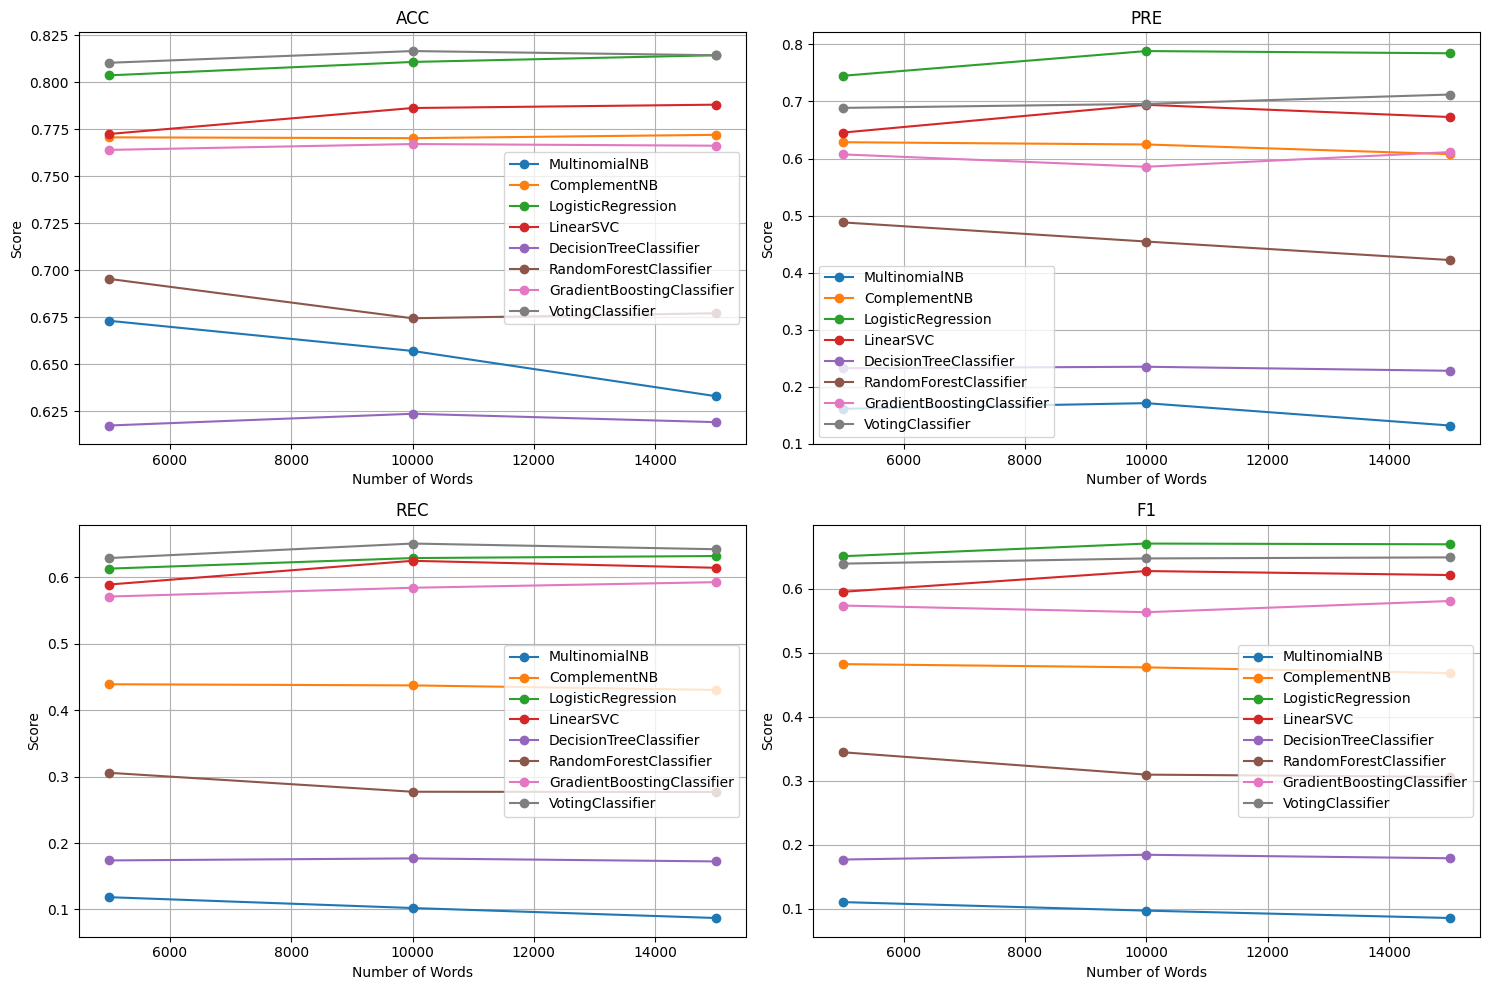

In [16]:
import matplotlib.pyplot as plt

# 서브플롯 생성
# 2행 2열의 구조로 총 4개의 그래프를 생성한다.
fig, axs = plt.subplots(2, 2, figsize=(15,10)) 

# 2차원 numpy array를 1차원으로 변환한다. 
# 이를 통해 각 그래프에 순차적으로 접근할 수 있다.
axs = axs.ravel() 

# 출력할 평가 지표들을 리스트로 정의한다.
measures = ['acc', 'pre', 'rec', 'f1']

# 각 평가 지표에 대해 반복문을 수행한다.
for i, measure in enumerate(measures):
    # common_dict 내의 각 모델에 대한 결과 값들을 순회한다.
    for model, model_result in common_dict.items():
        # 각 모델의 결과에서 단어 수를 추출한다. (key로 존재)
        num_words = list(model_result.keys())  
        # 해당하는 평가 지표의 값을 추출한다.
        scores = [model_result[n][measure] for n in num_words]  
        # 각 모델의 단어 수에 따른 평가 지표를 그래프로 그린다.
        axs[i].plot(num_words, scores, marker='o', label=model)  
    # 그래프의 제목을 설정한다. (대문자로 표시)
    axs[i].set_title(measure.upper())
    # x축의 라벨을 설정한다.
    axs[i].set_xlabel('Number of Words')
    # y축의 라벨을 설정한다.
    axs[i].set_ylabel('Score')
    # 범례를 설정한다.
    axs[i].legend()
    # 그리드를 표시한다.
    axs[i].grid()

# 각 그래프의 위치가 겹치지 않도록 조정한다.
plt.tight_layout()
# 그래프를 화면에 출력한다.
plt.show()


위 시각화 데이터를 기반으로, 각 머신러닝 모델의 성능 변화 추이와 그 원인에 대해 분석해자. 

1. **MultinomialNB와 ComplementNB** : 이 두 모델은 Naive Bayes 분류기로, 각 피처(단어)가 서로 독립적이라는 가정 하에 동작합니다. Vocabulary size가 증가함에 따라 성능이 감소하는 경향을 보인다. 이는 고차원이고 희소한 텍스트 데이터에서 독립 가정이 덜 유효하게 작용하고, 노이즈가 증가하기 때문이다.

2. **Logistic Regression과 LinearSVC** : 이 두 모델은 선형 분류 모델로, 텍스트 데이터의 고차원 및 희소한 특성을 잘 처리할 수 있다. Vocabulary size가 증가할수록 성능이 개선되는 경향을 보인다. 더 많은 단어를 사용하면 문서를 더 잘 표현하고 분류하는 데 도움이 되기 때문이다.

3. **DecisionTreeClassifier와 RandomForestClassifier** : 이 모델들은 트리 기반 모델로, 고차원이고 희소한 텍스트 데이터를 잘 처리하지 못하며, 선형적인 경계를 찾는 데 어려움이 있다. 따라서 Vocabulary size가 증가하더라도 성능의 큰 변화는 없다.

4. **GradientBoostingClassifier** : 이 모델은 부스팅 기법을 사용한 트리 기반 모델이다. 트리 기반 모델의 단점이 존재하지만, 각각의 약한 학습기를 결합함으로써 오차를 점진적으로 줄여나가는 특성 때문에 Vocabulary size가 증가함에 따라 일정한 성능 개선을 보인다.

5. **VotingClassifier** : 이 모델은 앙상블 기법 중 하나로, 여러 모델의 예측을 결합하여 최종 예측을 만듭니다. 이 방법으로 인해 다른 단일 모델들에 비해 좋은 성능을 보이며, Vocabulary size가 증가할수록 성능이 개선되는 경향을 보인다.

요약하자면, 선형 모델과 앙상블 모델은 Vocabulary size가 증가할수록 성능이 향상되는 반면, Naive Bayes와 트리 기반 모델은 성능 향상이 미미하거나 성능이 감소하는 경향을 보인다. 

이러한 성능 변화는 각 모델의 특성과 텍스트 데이터의 고차원 및 희소한 특성에 기인한다.

이를 통한 결론으로, 현재 상황에서 가장 최적의 모델은 로지스틱 회귀이며, 단어수는 10,000이 좋을 것으로 예상된다.





## 딥러닝 모델 구현하기

텍스트 분석에 사용할 수 있는 다양한 모델이 있다.
- 1D CNN
- RNN
- MLP

나는 이중에서 MLP를 선택했다.

실제로 텍스트 분류를 위해 사용되는 모델이기도 하지만, 사용하려는 데이터셋이 RNN이나 CNN에 맞지 않아 좋은 결과를 보여주지 않기 때문에, MLP를 최종적으로 선택했다.

In [19]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import numpy as np

# 데이터셋 로드
datasets = get_reuters_datasets()

# 훈련 데이터
X_train = datasets['train']['x'].toarray()  # toarray()를 사용해 희소 행렬을 밀집 배열로 변환
y_train = to_categorical(datasets['train']['y'])  # 원-핫 인코딩

# 테스트 데이터
X_test = datasets['test']['x'].toarray()
y_test = to_categorical(datasets['test']['y'])

# 데이터 입력 형태
input_shape = (X_train.shape[1],)

# 입력 레이어
inputs = Input(shape=input_shape)

# 레이어 추가
x = Dense(128, activation='relu')(inputs)

# 출력 레이어
outputs = Dense(46, activation='softmax')(x)

# 모델 정의
model_func = Model(inputs=inputs, outputs=outputs)

# 모델 컴파일
optimizer = Adam(learning_rate=0.001)
model_func.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 모델 학습
history = model_func.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# 모델 평가
score = model_func.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 예측 및 평가 메트릭 계산
y_pred = model_func.predict(X_test).argmax(axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Epoch 1/10
113/113 [==============================] - 2s 3ms/step - loss: 2.5298 - accuracy: 0.5303 - val_loss: 1.5801 - val_accuracy: 0.6605
Epoch 2/10
113/113 [==============================] - 0s 2ms/step - loss: 1.2734 - accuracy: 0.7191 - val_loss: 1.1547 - val_accuracy: 0.7513
Epoch 3/10
113/113 [==============================] - 0s 2ms/step - loss: 0.9052 - accuracy: 0.8058 - val_loss: 0.9739 - val_accuracy: 0.7919
Epoch 4/10
113/113 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.8578 - val_loss: 0.8698 - val_accuracy: 0.8108
Epoch 5/10
113/113 [==============================] - 0s 2ms/step - loss: 0.5124 - accuracy: 0.8923 - val_loss: 0.8055 - val_accuracy: 0.8280
Epoch 6/10
113/113 [==============================] - 0s 2ms/step - loss: 0.3876 - accuracy: 0.9180 - val_loss: 0.7653 - val_accuracy: 0.8353
Epoch 7/10
113/113 [==============================] - 0s 2ms/step - loss: 0.2965 - accuracy: 0.9367 - val_loss: 0.7399 - val_accuracy: 0.8358
Epoch 

c:\Users\tama0\anaconda3\envs\tf39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


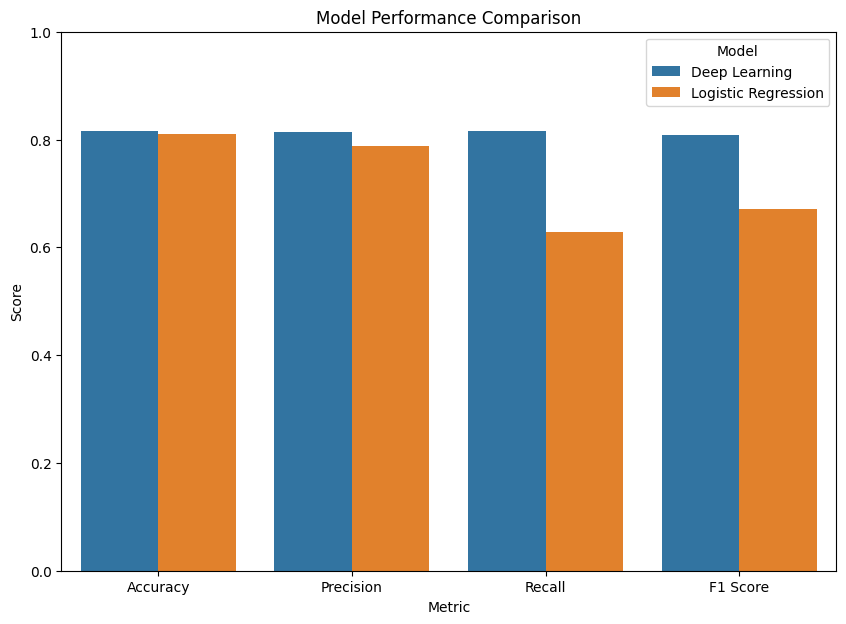

In [20]:
# 데이터 프레임을 생성합니다.
df = pd.DataFrame({
    'Model': ['Deep Learning', 'Logistic Regression'],
    'Accuracy': [accuracy, common_dict['LogisticRegression'][10000]['acc']],
    'Precision': [precision, common_dict['LogisticRegression'][10000]['pre']],
    'Recall': [recall, common_dict['LogisticRegression'][10000]['rec']],
    'F1 Score': [f1, common_dict['LogisticRegression'][10000]['f1']]
})

# "Long Format"으로 변경합니다.
df = pd.melt(df, id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10,7))
sns.barplot(x='Metric', y='Score', hue='Model', data=df)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)  # y축 범위를 0과 1사이로 설정합니다.
plt.show()


### 결론

일반적으로 딥러닝은 로지스틱 회귀보다 훨씬 더 복잡한 패턴을 학습할 수 있다.  
딥러닝의 경우, 여러 레이어를 쌓거나 드롭아웃등을 통해 다양하게 텍스트를 처리할 수 있는 반면, 로지스틱 회귀는 단어 빈도수와 같은 기본적인 특징을 사용할 때, 상당히 제한적인 부분이 있다고 볼 수 있다.

또한 딥러닝 모델은 표현 학습을 통해 입력 데이터에서 유용한 특징을 학습할 수 있다.  
특히 텍스트의 경우, numeric data 대비 훨씬 복잡하기 때문에 이러한 장점이 중요하다.  
하지만, 로지스틱 회귀는 사전에 정의된 특징, 우리가 사용한 TF-IDF 등에 의존하기 때문에, 항상 해당 문제를 충분히 설명할 수 있다고 보기 힘들다.

물론 하이퍼 파라미터를 좀 더 커스텀하면 더 나은 성능을 보여줄 수 있지만, 지금 당장 검색만해도, 텍스트 처리에는 딥러닝이나 트랜스포머를 고려하라는 말이 나오고 있는 실정이긴 하다.

위의 이러한 특징들, 딥러닝의 표현 학습과 복잡한 패턴을 학습할 수 있는,이 로지스틱 회귀에 비해서 좀 더 좋은 성능이 나올 수 있게 된 요인으로 보인다.
